# How to improve controls for parking violations
Correlation of the number of parking violations with the time of day and the weather

Final Report AMSE/SAKI

Jannik Kiesel

# Introduction

This project aims to investigate the relationship between the time of day, air temperature, and parking violations in the city of Bonn. By analyzing the available data sources, including weather data of Bonn and records of warnings and fines for parking violations in 2022, we seek to determine the extent to which these factors influence parking violations in the city.

The City of Bonn can greatly benefit from the findings of this analysis as it will enable them to predict and anticipate the occurrence of parking violations at different times of day, days of the week, and temperatures. Armed with this knowledge, city authorities can develop a more effective concept to prevent parking violations in Bonn.

The first data source for this analysis is the weather data of Bonn, which provides information on the air temperature at various points throughout the day. By correlating this temperature data with parking violation records, we can explore whether there is a link between temperature and the likelihood of parking violations occurring.

The second data source comprises the warnings and fines issued for stationary traffic, specifically parking violations, in Bonn during the year 2022. This dataset provides valuable insights into the frequency and distribution of parking violations across different times and days. By combining this information with the weather data, we can uncover patterns and trends that shed light on the influence of time of day and air temperature on parking violations.

Ultimately, the results of this analysis will empower the City of Bonn to devise a new and more effective approach to prevent parking violations. By understanding the factors that contribute to these violations, city authorities can implement targeted strategies, such as adjusting parking regulations or increasing enforcement efforts during specific periods. This proactive approach will not only help improve traffic management but also enhance the overall urban experience for residents and visitors alike.

In summary, through the examination of weather data and parking violation records, this project aims to ascertain the influence of time of day and air temperature on parking violations in Bonn. By leveraging these findings, the City of Bonn can develop informed strategies to predict and prevent parking violations, contributing to a more efficient and hassle-free urban environment.

# Import packages and data

In [119]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# Set the desired number of rows
pd.set_option('display.max_rows', 400)  

In [120]:
# Import weather
database_path = "../data/weather_data.db"
conn = sqlite3.connect(database_path)
cursor = conn.cursor()
cursor.execute("SELECT * FROM weather")
rows = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
df_weather = pd.DataFrame(rows, columns=column_names)
cursor.close()
conn.close()

In [121]:
# Import parking violations
database_path = "../data/parkverstoesse_bonn.db"
conn = sqlite3.connect(database_path)
cursor = conn.cursor()
cursor.execute("SELECT * FROM parking_violations")
rows = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
df_parking = pd.DataFrame(rows, columns=column_names)
cursor.close()
conn.close()

# Data processing

In [122]:
# Merge data frames
df_parking['hour'] = df_parking['tatzeit'] // 100 # Calculate hour from tatzeit
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.strftime('%d.%m.%Y')

In [123]:
df_parking.tail()

,tattag,tatzeit,tatort,tatbestandbe_tbnr,geldbusse,bezeichnung,hour
107902,31.12.2020,1144,Michaelstraße in Höhe Hsnr. 11,142103,10,PKW,11
107903,31.12.2020,1144,Michaelstraße v. Hsnr. 20,142103,10,PKW,11
107904,31.12.2020,1000,Münsterstraße 18,141106,30,PKW,10
107905,31.12.2020,1120,Münsterstraße 18,141106,30,PKW,11
107906,31.12.2020,1434,Poststraße 22,141106,30,PKW,14


In [124]:
df_weather.tail()

,date,hour,temperature,dew_point,humidity,precipitation,snow_depth,wind_direction,wind_speed,wind_gust,pressure,sunshine,weather_condition
414226,06.07.2023,8,19.4,12.2,63.0,NaN,None,268.0,11.1,20.4,1016.6,NaN,2.0
414227,06.07.2023,9,20.6,11.8,57.0,NaN,None,273.0,13.0,22.2,1016.6,NaN,2.0
414228,06.07.2023,10,21.6,11.6,53.0,NaN,None,275.0,13.0,22.2,1016.5,NaN,2.0
414229,06.07.2023,11,22.4,11.2,49.0,NaN,None,312.0,14.8,22.2,1018.4,NaN,2.0
414230,06.07.2023,12,23.1,11.2,47.0,NaN,None,307.0,14.8,24.1,1018.2,NaN,2.0


In [125]:
# Drop data
df_parking = df_parking[['tattag', 'hour', 'tatbestandbe_tbnr']]
df_weather = df_weather[['date', 'hour', 'temperature']]

In [126]:
# Merge dataframes
df = pd.merge(df_weather, df_parking, left_on=['date', 'hour'], right_on=['tattag', 'hour'])

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107907 entries, 0 to 107906
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               107907 non-null  object 
 1   hour               107907 non-null  int64  
 2   temperature        107907 non-null  float64
 3   tattag             107907 non-null  object 
 4   tatbestandbe_tbnr  107907 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [128]:
df.head()

,date,hour,temperature,tattag,tatbestandbe_tbnr
0,01.01.2020,1,0.1,01.01.2020,112404
1,01.01.2020,10,0.9,01.01.2020,141324
2,01.01.2020,13,4.5,01.01.2020,142252
3,01.01.2020,13,4.5,01.01.2020,142278
4,01.01.2020,15,4.2,01.01.2020,142278


# Results

## Research question 1: Influence of time of day on parking violations

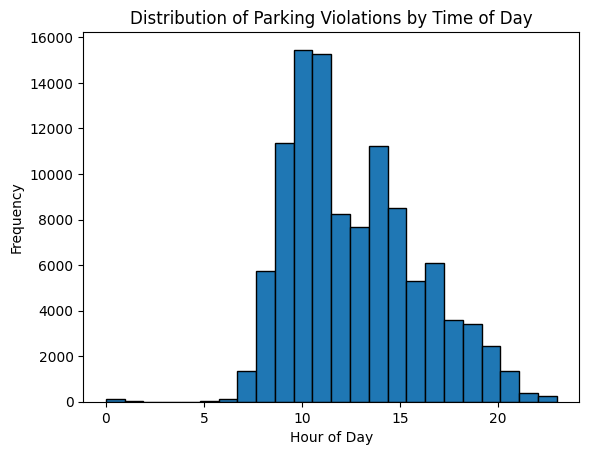

In [129]:
# Visualize the distribution of parking violations by time of day
plt.hist(df['hour'], bins=24, edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Parking Violations by Time of Day')
plt.show()

We now concentrate on parking violations between 8 am and 8 pm:

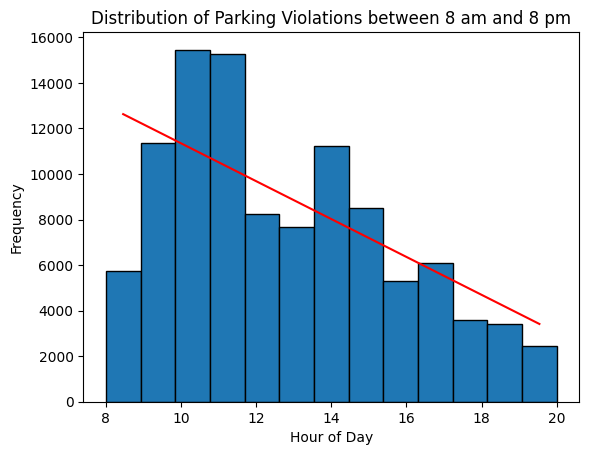

In [130]:
# Visualize the distribution of parking violations between 8 am and 8 pm
filtered_df = df[(df['hour'] >= 8) & (df['hour'] <= 20)]
hist, bins, _ = plt.hist(filtered_df['hour'], bins=13, edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Parking Violations between 8 am and 8 pm')

# Linear regression
x = (bins[:-1] + bins[1:]) / 2  # Use bin centers as x values
y = hist
coefficients = np.polyfit(x, y, 1)
trendline = np.polyval(coefficients, x)
plt.plot(x, trendline, color='r')

plt.show()


Interpretation

The correlation is negative. This means that fewer parking violations occur later in the day. Especially between 10 and 12 o'clock there are many parking violations. Hardly any parking violations occur after 5 pm. This may be due to the fact that the core working hours of the public order office end at 5 p.m. and/or that some parking spaces allow free parking after a certain time.

## Research question 2: Influence of temperature on parking violations

In [ ]:
# Mean temperature per day
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather = df_weather[df_weather['date'].dt.year == 2020]

dfs = []
unique_dates = df_weather['date'].dt.date.unique()
for date in unique_dates:
    df_filtered = df_weather[df_weather['date'].dt.date == date]
    avg_temperature = df_filtered['temperature'].mean()
    new_df = pd.DataFrame({'date': [date], 'temperature': [avg_temperature]})
    dfs.append(new_df)

# Concatenate all the DataFrames in the list
df_average_temp = pd.concat(dfs, ignore_index=True)

# Round
df_average_temp['temperature'] = df_average_temp['temperature'].round()

In [132]:
df_average_temp.info()
df_average_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         366 non-null    object 
 1   temperature  366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


,date,temperature
0,2020-01-01,1.0
1,2020-02-01,2.0
2,2020-03-01,7.0
3,2020-04-01,5.0
4,2020-05-01,5.0


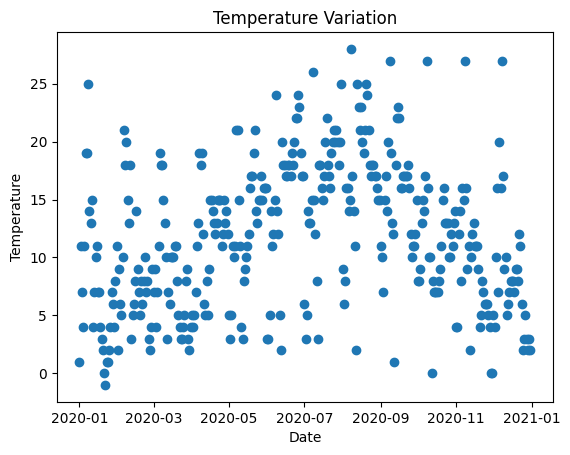

In [133]:
# Plot of temperature data
plt.scatter(df_average_temp['date'], df_average_temp['temperature'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Variation')
plt.show()


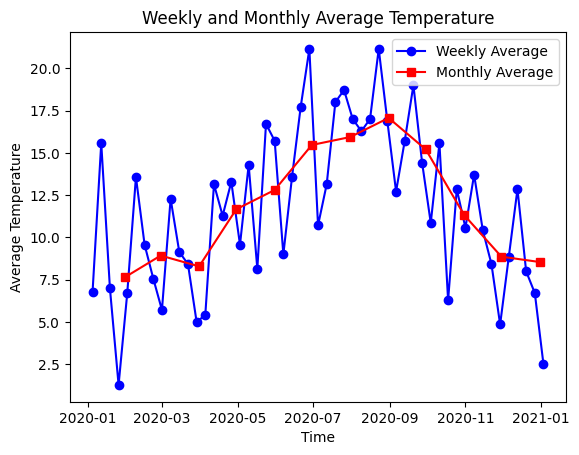

In [134]:
# Weekly and monthly average temperature

df_average_temp['date'] = pd.to_datetime(df_average_temp['date'])
df_weekly_avg_temp = df_average_temp.resample('W', on='date').mean()
df_monthly_avg_temp = df_average_temp.resample('M', on='date').mean()

# Plotting the grouped data
plt.plot(df_weekly_avg_temp.index, df_weekly_avg_temp['temperature'], marker='o', color='blue', label='Weekly Average')
plt.plot(df_monthly_avg_temp.index, df_monthly_avg_temp['temperature'], marker='s', color='red', label='Monthly Average')
plt.xlabel('Time')
plt.ylabel('Average Temperature')
plt.title('Weekly and Monthly Average Temperature')
plt.legend()
plt.show()

In [ ]:
# Merge the dataframes on 'date' and 'tattag' columns
df_parking['tattag'] = pd.to_datetime(df_parking['tattag'])
df = pd.merge(df_average_temp, df_parking, left_on='date', right_on='tattag', how='left')
df['count_PV'] = df['tatbestandbe_tbnr'].notna().astype(int)
df = df.rename(columns={'date': 'date', 'temperature': 'temperature'})
df = df[['date', 'temperature', 'count_PV']]
df = df.groupby('date', as_index=False).agg({'temperature': 'first', 'count_PV': 'sum'})
df = df.sort_values('date')
df = df.reset_index(drop=True)

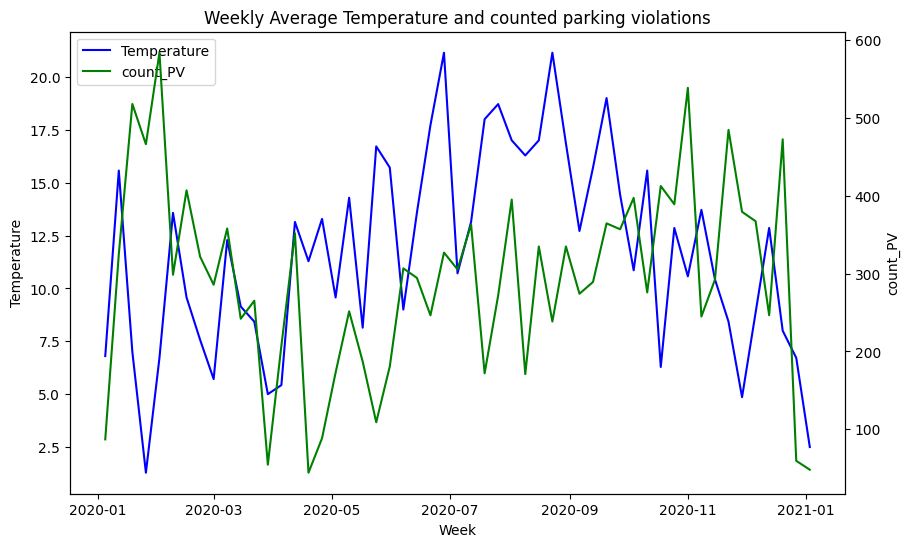

In [136]:
# Weekly average temperature in relation to counted parking violations

df.set_index('date', inplace=True)
weekly_avg = df.resample('W').mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(weekly_avg.index, weekly_avg['temperature'], color='blue', label='Temperature')
ax1.set_ylabel('Temperature')
ax2 = ax1.twinx()
ax2.plot(weekly_avg.index, weekly_avg['count_PV'], color='green', label='count_PV')
ax2.set_ylabel('count_PV')
plt.title('Weekly Average Temperature and counted parking violations')
ax1.set_xlabel('Week')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

plt.xticks(rotation=45)
plt.show()

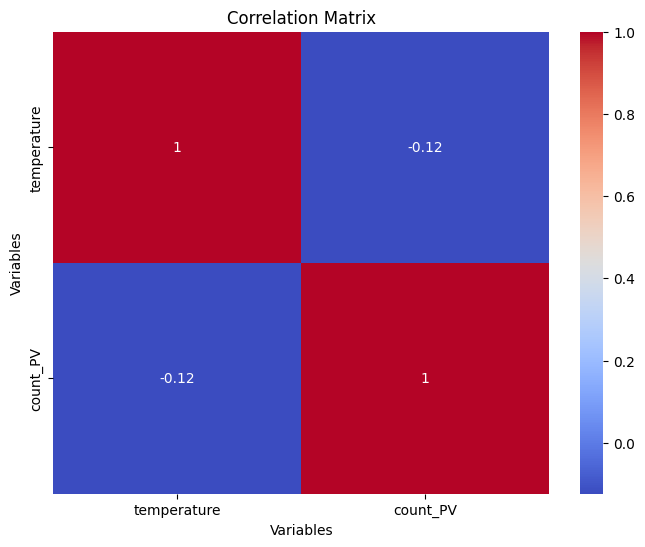

In [137]:
# Correllation matrix
correlation_matrix = df[['temperature', 'count_PV']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

In [138]:
# New dataframe with the Temperature and the average parking violations per temperature
result_df = df.groupby('temperature')['count_PV'].mean().round().reset_index()

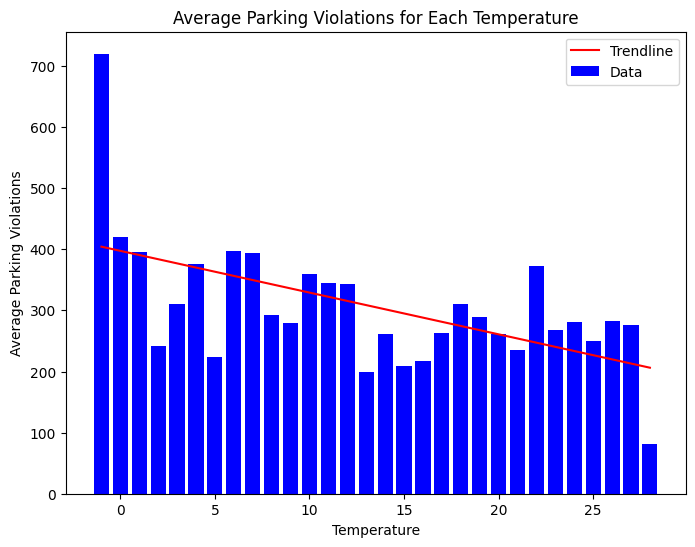

In [139]:
# Plotting result_df

# Trendline
x = result_df['temperature']
y = result_df['count_PV']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
x_range = np.linspace(x.min(), x.max(), 100)
y_range = trendline(x_range)

plt.figure(figsize=(8, 6))
plt.bar(x, y, color='blue', label='Data')
plt.plot(x_range, y_range, color='red', label='Trendline')
plt.xlabel('Temperature')
plt.ylabel('Average Parking Violations')
plt.title('Average Parking Violations for Each Temperature')
plt.legend()
plt.show()

Interpretation

The correlation is slightly negative. This means that the higher the temperature, the less parking violations occur.

# Discussion

### Research Question 1

The analysis of the parking violation records in the city of Bonn revealed that the majority of parking violations occur during the morning hours between 9 a.m. and 12 p.m. This finding suggests that there may be specific factors or circumstances during this time period that contribute to a higher likelihood of parking violations. It could be speculated that increased traffic or higher demand for parking spaces during the morning rush hour may be influencing this trend. Additionally, it is possible that limited parking availability or stricter enforcement during these hours could be contributing factors. Further research and investigation are needed to understand the underlying reasons for this pattern and to explore potential measures to alleviate the issue.

Result: Fewer parking violations occur later in the day


### Research Question 2

The analysis also explored the relationship between air temperature and parking violations in Bonn. The results indicated a correlation between warmer temperatures and a decrease in the number of recorded parking violations. This finding suggests that as the temperature rises, the occurrence of parking violations tends to decrease. However, caution must be exercised in interpreting these results. It should be noted that the analysis assumes a consistent level of parking violation enforcement throughout the day, from 8 a.m. to 8 p.m. It is important to consider the possibility of variations in enforcement efforts due to shifting work schedules or other factors. Therefore, while the correlation between temperature and parking violations is observed, additional research is needed to validate and understand the underlying mechanisms behind this relationship.

Result: Only slight correlation between temperature
and number of parking violations


### Conclusion

In conclusion, this study investigated the influence of time of day and air temperature on parking violations in the city of Bonn. The findings revealed that the highest number of parking violations occurs during the morning hours between 9 a.m. and 12 p.m., indicating the need for targeted interventions during this period. Furthermore, a negative correlation was observed between air temperature and parking violations, suggesting that warmer temperatures are associated with a decrease in parking violations. However, it is crucial to exercise caution when interpreting these results and acknowledge the potential influence of varying enforcement efforts throughout the day. The insights gained from this research can inform the City of Bonn in developing effective strategies to predict and prevent parking violations, leading to improved traffic management and a more pleasant urban experience for residents and visitors alike.


### Limitations

Limitations should be considered when interpreting the results of this study. It is important to exercise caution in drawing conclusions based on the findings. Additionally, it should be noted that the controls utilized in the study may not have equal strength or effectiveness at all times. Factors such as varying conditions or circumstances could impact their reliability. Moreover, it is essential to acknowledge that there exist different no parking zones that are enforced at different times. This temporal variation in parking restrictions should be taken into account when analyzing the data or making any related judgments.